In [8]:
from google.colab import drive 
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [10]:
%cd /gdrive/My Drive/김경민/Stroke/codeipynb
!pwd

[Errno 20] Not a directory: '/gdrive/My Drive/김경민/Stroke/code.ipynb'
/gdrive/My Drive/김경민/Stroke
/gdrive/My Drive/김경민/Stroke


In [ ]:
!git init

Initialized empty Git repository in /gdrive/My Drive/김경민/Stroke/.git/


In [ ]:
!git config --global user.email "keung903@naver.com"
!git config --global user.name "honor-sky"

In [ ]:
!git add .

error: open("save_result_실험1_all(109).gsheet"): Operation not supported
error: unable to index file 'save_result_실험1_all(109).gsheet'
fatal: adding files failed


In [ ]:
!pip install pymrmr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 KB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pymrmr: filename=pymrmr-0.1.11-cp39-cp39-linux_x86_64.whl size=352735 sha256=fc522c50bc360c4c4fa87e2dc1d2dfbcdfff445ba99850af260846a93285932d
  Stored in directory: /root/.cache/pip/wheels/60/c9/7e/17469ad924ae6c1a21cf2664f601f4c26dc8a9bb0a445b30cf
Successfully built pymrmr


In [ ]:
import pandas as pd
import numpy as np
import os
import random
#import torch
import pymrmr
from keras.integration_test.preprocessing_test_utils import preprocessing
from sklearn.cluster import KMeans
from sklearn.feature_selection import RFE, SequentialFeatureSelector, RFECV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from itertools import permutations
from itertools import combinations
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [ ]:
#### 결측값 정리, 컬럼 정리 ####
# delete unnecceary column
# preprocceing NA value
# 수치형, 범주형 데이터 처리

def clean_df(df, categorical_col = None, threshold=0.9):
    '''
    DataFrame을 입력받아 threshold 값 이상으로 nan 값이 존재하는 열을 제거하고 그 이하는 행을 제거한다.
    '''
    thresh = int(len(df) * threshold)
    target_cols = set(df.columns).difference(set(df.dropna(axis=1, thresh=thresh)))

    # 대상 열 삭제
    print(f'허용치 이상의 결측치가 존재하는 열들을 제거합니다.\n대상 열: {target_cols}')
    df_clean = df.dropna(axis=1, thresh=thresh)

    # 결측치가 존재하는 행 삭제
    print(f'결측치가 발견된 행을 제거합니다.\n삭제 대상 레코드 수: {len(df_clean) - len(df_clean.dropna())}')
    df_clean = df_clean.dropna()


    # 범주형 데이터를 one-hot encoding
    if categorical_col is not None:
      '''
      print(f'범주형 데이터 : {df_clean[categorical_col]}')
      ohe = OneHotEncoder(sparse=False) 
      ohe.fit(df_clean[categorical_col])
      ohe_encoded = ohe.transform(df_clean[categorical_col])

      new_cat = pd.DataFrame(ohe_encoded)
      #print(new_cat)
      df_clean = pd.concat([df_clean, new_cat], axis=1)
      df_clean.drop(categorical_col, axis=1, inplace=True)
      '''
      df_clean = pd.get_dummies(df_clean, columns=categorical_col)


    ''' 성별 별로 데이터셋 따로 생성 논의 '''

    return df_clean

In [ ]:
#### clustering ####
def cluster(df, isDummy, categorical_col = None):
    random.seed(123)

    # one-hot encoding for culstering
    if not isDummy: 
      df_clean = pd.get_dummies(df, columns=categorical_col)

    # label을 제외한 데이터셋 추출
    df_no_label = pd.DataFrame(df.drop(['Reattack'], axis='columns'))

    df_scale = pd.DataFrame(StandardScaler().fit_transform(df_no_label))
    print(f'클러스터링을 위해 표준화 한 데이터셋 : \n {df_scale}')

    # 클러스터 생성
    kmeans = KMeans(n_clusters=10,random_state=123)
    kmeans.fit(df_scale)

    return kmeans.labels_

# Split Dataset
*   train,test 으로 분리
*   성별이 중요한 feature로 뽑히면 따로 만들기


In [ ]:
# 모비율을 반영 데이터셋 구성 => test 데이터셋의 정상,비정상 데이터가 모비율을 반영
def split_dataset(df_clean, isDummy, categorical_col = None):
    random.seed(123)

    # 클래스 별로 분리
    df_cls1 = df_clean[df_clean['Reattack'] == 0]
    df_cls2 = df_clean[df_clean['Reattack'] == 1]

    # train/validation/test 데이터셋 인덱스 생성
    cls1_idx = df_cls1.index
    cls2_idx = df_cls2.index

    # 10개의 클러스터로 나누기
    cluster_ids = cluster(df_cls1, isDummy, categorical_col)

    # 병변 데이터 추출
    train_idx_diea = np.random.choice(cls2_idx, CFG['TRAIN_SIZE'][1])  # train 
    cls2_idx = df_cls2.drop(train_idx_diea[0]).index # 뽑은거 지워주기
    test_idx_diea = np.random.choice(cls2_idx, CFG['TEST_SIZE'][1])    # test

    train_idx_nor = []
    test_idx_nor = []
    for i in range(0,10):
        clust = df_cls1[cluster_ids == i]
        clust_index = list(clust.index)

        # train 
        tmp_idx = []
        if(len(clust_index) < 40):  # 하나의 클러스터에 데이터가 25개보다 모자른 경우 
            tmp_idx.append(clust_index)
            train_idx_nor.append(sum(tmp_idx, []))

            for li in sum(tmp_idx, []):
                clust_index.remove(li)
        else:
            tmp_idx.append(random.sample(clust_index, 40))
            train_idx_nor.append(sum(tmp_idx, []))

            for li in sum(tmp_idx, []):
                clust_index.remove(li)

        # test
        if(len(clust_index) < 40):
            test_idx_nor.append(clust_index)
        else:
            test_idx_nor.append(random.sample(clust_index, 40))


    train_idx_nor = sum(train_idx_nor, [])
    test_idx_nor = sum(test_idx_nor, [])

    # train/validation/test 데이터셋 생성
    df_train = pd.concat([df_cls1.loc[train_idx_nor], df_cls2.loc[train_idx_diea]], ignore_index=True)
    df_test = pd.concat([df_cls1.loc[test_idx_nor], df_cls2.loc[test_idx_diea]], ignore_index=True)

    print(f'train : {df_train}\n test : {df_test}\n')
    return df_train,df_test

In [ ]:
# kfold용 데이터셋 => 정상,비정상 데이터셋을 1:1로 구성
def split_dataset_kfold(df_clean, isDummy, categorical_col = None):
    random.seed(100)
    # 클래스 별로 분리
    df_cls1 = df_clean[df_clean['Reattack'] == 0]
    df_cls2 = df_clean[df_clean['Reattack'] == 1]

    # train/validation/test 데이터셋 인덱스 생성
    cls1_idx = df_cls1.index
    cls2_idx = df_cls2.index

    # 정상데이터를 클러스터링해 균일한 데이터셋 구성
    cluster_ids = cluster(df_cls1, isDummy, categorical_col)

    idx_nor = []
    for i in range(0, 10):
        clust = df_cls1[cluster_ids == i]
        clust_index = clust.index

        if (len(clust_index) < 30):
            idx_nor.append(list(clust_index))
        else:
            idx_nor.append(random.sample(list(clust_index), 30))

    idx_nor = sum(idx_nor,[])
    # train/validation/test 데이터셋 생성
    train_test = pd.concat([df_cls1.loc[idx_nor], df_cls2], ignore_index=True)

    return train_test

#Wrapper method

In [ ]:
# backward
def backward_elimination(X, y, MODELS, n_features=15):
    fs = {}
    print(X)
    print(y)

    for name, model in MODELS.items():
        print(f'===== {name} Backward Elimination 시작 =====')
        if name != 'SVM':
          rfe = RFE(model, n_features_to_select=n_features)
        else:
          rfe = RFECV(estimator=model, scoring='roc_auc')
        fit = rfe.fit(X, y)

        fs[name] = X.columns[fit.support_].tolist()

    return fs


In [ ]:
# forward
def forward_selection(X, y, MODELS, n_features=15):
    fs = {}

    for name, model in MODELS.items():
        print(f'===== {name} Forward Selection 시작 =====')
        sfs = SequentialFeatureSelector(model, n_features_to_select=n_features, scoring='roc_auc', n_jobs=-1)
        sfs.fit(X, y)

        fs[name] = X.columns[sfs.get_support()].tolist()

    return fs

def wrapper_method(X, y, MODELS, typ, n_features=15):
    if typ == 'BACK':
        fs = backward_elimination(X, y, MODELS, n_features)
    else:
        fs = forward_selection(X, y, MODELS, n_features)

    return fs

#Combination

#K-Fold

In [ ]:
### K-fold ###
def k_folds(df_clean, save_version, fs = None):

    save_result = pd.DataFrame(index=range(0,8), columns = {'fold1','fold2', 'fold3','fold4','fold5','평균'})


    X = df_clean.drop('Reattack',axis=1)
    y = df_clean['Reattack']

    kf = KFold(n_splits=5, shuffle=True, random_state=123)

    accuracy_history_xgb = []
    accuracy_history_rf = []
    accuracy_history_svm = []
    accuracy_history_dt = []

    count = 1

    for train_index, test_index in kf.split(X):
        print(f'{count}번 fold 결과입니다.\n')

        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        # 모델 선언
        model_rf = RandomForestClassifier(random_state=123)  
        model_xgb = XGBClassifier(random_state=123)
        model_svm = SVC(random_state=123)
        model_dt = DecisionTreeClassifier(random_state=123)

        if fs is None:
          # 모델 학습
            model_xgb.fit(X_train, y_train)
            model_rf.fit(X_train, y_train)  
            model_svm.fit(X_train, y_train)
            model_dt.fit(X_train, y_train)

            # 예측 라벨
            pred_xgb = model_xgb.predict(X_test)
            pred_rf = model_rf.predict(X_test)  
            pred_svm = model_svm.predict(X_test)
            pred_dt = model_dt.predict(X_test)

            # 정확도 측정 및 기록
            accuracy_history_xgb.append(accuracy_score(pred_xgb, y_test))
            accuracy_history_rf.append(accuracy_score(pred_rf, y_test))  
            accuracy_history_svm.append(accuracy_score(pred_svm, y_test))
            accuracy_history_dt.append(accuracy_score(pred_dt, y_test))        

        else:
          # 모델 학습
            model_xgb.fit(X_train[fs['XGB']], y_train)
            model_rf.fit(X_train[fs['RF']], y_train)  
            model_svm.fit(X_train[fs['SVM']], y_train)
            model_dt.fit(X_train[fs['DT']], y_train)

            # 예측 라벨
            pred_xgb = model_xgb.predict(X_test[fs['XGB']])
            pred_rf = model_rf.predict(X_test[fs['RF']])  
            pred_svm = model_svm.predict(X_test[fs['SVM']])
            pred_dt = model_dt.predict(X_test[fs['DT']])

            # 정확도 측정 및 기록
            accuracy_history_xgb.append(accuracy_score(pred_xgb, y_test))
            accuracy_history_rf.append(accuracy_score(pred_rf, y_test))  
            accuracy_history_svm.append(accuracy_score(pred_svm, y_test))
            accuracy_history_dt.append(accuracy_score(pred_dt, y_test))
            


        print("각 분할의 정확도 기록(xgb) :", accuracy_score(pred_xgb, y_test))
        print("각 분할의 confusion matrix 기록(xgb) :", confusion_matrix(y_test, pred_xgb))
        save_result.iloc[0,count-1] = accuracy_score(pred_xgb, y_test)
        save_result.iloc[1,count-1] = confusion_matrix(y_test, pred_xgb)

        print("각 분할의 정확도 기록(rf) :", accuracy_score(pred_rf, y_test))
        print("각 분할의 confusion matrix 기록(rf) :", confusion_matrix(y_test, pred_rf))
        save_result.iloc[2,count-1] = accuracy_score(pred_rf, y_test)
        save_result.iloc[3,count-1] = confusion_matrix(y_test, pred_rf)

        print("각 분할의 정확도 기록(svm) :", accuracy_score(pred_svm, y_test))
        print("각 분할의 confusion matrix 기록(svm) :", confusion_matrix(y_test, pred_svm))
        save_result.iloc[4,count-1] = accuracy_score(pred_svm, y_test)
        save_result.iloc[5,count-1] = confusion_matrix(y_test, pred_svm)


        print("각 분할의 정확도 기록(dt) :", accuracy_score(pred_dt, y_test))
        print("각 분할의 confusion matrix 기록(dt) :", confusion_matrix(y_test, pred_dt))
        save_result.iloc[6,count-1] = accuracy_score(pred_dt, y_test)
        save_result.iloc[7,count-1] = confusion_matrix(y_test, pred_dt)

        count += 1


    print("평균 정확도(xgb) :", np.mean(accuracy_history_xgb))
    print("평균 정확도(rf) :", np.mean(accuracy_history_rf))
    print("평균 정확도(svm) :", np.mean(accuracy_history_svm))
    print("평균 정확도(dt) :", np.mean(accuracy_history_dt))

    save_result.iloc[0,count-1] = np.mean(accuracy_history_xgb)
    save_result.iloc[2,count-1] = np.mean(accuracy_history_rf)
    save_result.iloc[4,count-1] = np.mean(accuracy_history_svm)
    save_result.iloc[6,count-1] = np.mean(accuracy_history_dt)

    #save_result.to_csv(f'save_result_실험4_{save_version}.csv') #csv파일로 생성
    #return np.mean(accuracy_history_rf), np.mean(accuracy_history_xgb)

# Main 코드 입니다

In [ ]:
MODELS = {
        'DT': DecisionTreeClassifier(),
        'SVM': SVC(kernel='linear'),
        'XGB': XGBClassifier(),
        'RF': RandomForestClassifier(),
    }

In [ ]:
# 데이터셋 불러오기
df = pd.read_excel('결측치 제거.xlsx')
print(f'정상데이터: {len(df[df["Reattack"]==0])}, 비정상데이터: {len(df[df["Reattack"]>=1])}')
print(df)

# lable (1이상은 모두 1로 변환)
df.loc[df['Reattack'] >= 1, 'Reattack'] = 1

# Gender, thrombectomy 데이터 변환 추가 작업 필요
df.loc[df['Gender'] == 'M', 'Gender'] = 1
df.loc[df['Gender'] == 'F', 'Gender'] = 0


print(df.head)
print(f'정상데이터: {len(df[df["Reattack"]==0])}, 비정상데이터: {len(df[df["Reattack"]==1])}')
df.describe()

정상데이터: 1167, 비정상데이터: 251
     hospital        ID Gender   Age  Reattack  Ethnicity  Marital status  \
0        DKUH  12551107      1  23.0       0.0        1.0             0.0   
1        DKUH    863270      1  86.0       0.0        0.0             1.0   
2        DKUH   8326403      0  90.0       0.0        0.0             1.0   
3        DKUH    459657      1  54.0       0.0        0.0             1.0   
4        DKUH    918707      1  60.0       0.0        0.0             1.0   
...       ...       ...    ...   ...       ...        ...             ...   
1484     CNUH   3008166      F  80.0       0.0        0.0             1.0   
1485     CNUH   1717456      F  84.0       0.0        0.0             2.0   
1486     CNUH    303289      F  90.0       0.0        0.0             1.0   
1487     CNUH    462604      M  78.0       1.0        0.0             1.0   
1488     CNUH   1114812      M  85.0       0.0        0.0             1.0   

      Employment status  Education level  Alcohol 

,ID,Age,Reattack,Ethnicity,Marital status,Employment status,Education level,"Alcohol (0,1,2)","Smoking (0,1,2)","Duration of smoking, years",...,FIM3_Cog_expression,FIM3_Cog_social interaction,FIM3_Cog_problem solving,FIM3_Cog_memory,FIM3_Cog_total,FIM3_Total,*Med_anticoagulant,"*Multiple embolic (0,1)",*cingulate gyrus,*central gyrus
count,1.489000e+03,1419.000000,1418.000000,1416.000000,1415.000000,1389.000000,1162.000000,1416.000000,1416.000000,369.00000,...,490.000000,490.000000,490.000000,490.000000,503.000000,511.000000,279.000000,275.000000,275.0,275.000000
mean,5.747465e+06,67.050035,0.177010,0.007768,1.086926,0.402448,1.858864,0.368644,0.422316,33.52439,...,4.944898,4.781633,4.400000,4.473469,23.815109,74.407045,0.121864,0.007273,0.0,0.018182
std,7.343038e+06,13.504621,0.381812,0.087826,0.413961,0.490568,1.226626,0.545828,1.002278,13.78452,...,1.914060,1.994694,2.055269,2.005185,9.243045,28.609862,0.327716,0.085125,0.0,0.180319
min,2.260000e+02,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.50000,...,1.000000,1.000000,1.000000,1.000000,5.000000,18.000000,0.000000,0.000000,0.0,0.000000
25%,1.548441e+06,58.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,24.00000,...,4.000000,3.000000,3.000000,3.000000,17.000000,54.000000,0.000000,0.000000,0.0,0.000000
50%,4.612784e+06,69.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,30.00000,...,5.000000,5.000000,4.000000,4.500000,25.000000,75.000000,0.000000,0.000000,0.0,0.000000
75%,8.750099e+06,77.000000,0.000000,0.000000,1.000000,1.000000,3.000000,1.000000,1.000000,40.00000,...,7.000000,7.000000,6.000000,6.000000,33.000000,97.000000,0.000000,0.000000,0.0,0.000000
max,8.390922e+07,96.000000,1.000000,1.000000,2.000000,1.000000,4.000000,2.000000,30.000000,70.00000,...,7.000000,7.000000,7.000000,7.000000,35.000000,126.000000,1.000000,1.000000,0.0,2.000000


In [ ]:
categorical_columns = ['Alcohol (0,1,2)', 'Smoking (0,1,2)'] # 범주형 데이터 설정 # ['pre_mrs','TOAST','dis_mrs']

In [ ]:
# 결측치 제거 및 원핫코딩
clean_df = clean_df(df, categorical_columns)
print(f'결측치 제거한 데이터셋(정상데이터: {len(clean_df[clean_df["Reattack"]==0])}, 비정상데이터: {len(clean_df[clean_df["Reattack"]==1])})')

# 한글 데이터, 불필요한 데이터 등
clean_df.drop(['hospital','ID'], axis=1, inplace=True) # thrombectomy 는 이상한 값이 포함되어 있어 문제

clean_df['Gender'] = pd.to_numeric(clean_df['Gender'])
clean_df.drop(clean_df[clean_df['thrombectomy'] == " "].index, axis = 0, inplace=True)
clean_df['thrombectomy'] = pd.to_numeric(clean_df['thrombectomy'])

print(clean_df)

허용치 이상의 결측치가 존재하는 열들을 제거합니다.
대상 열: {'FIM2_SP_total', 'Initial M/P_LL', 'FIM1_SP_total', 'FIM1_TL_total', 'FIM1_SC_dressing lower body', 'FIM1_Total', 'GCS1_E', 'FIM2_Cog_problem solving', 'BMI', 'Bstage2_U/Ex', 'FIM3_SP_bladder', 'M/P1_total', 'FIM3_T/L_toilet', 'MBI2_7', 'MBI2_3', 'GCS1_V', 'GCS1_total', 'FIM2_SP_bowel', 'FIM2_SP_bladder', 'FIM3_SC_total', 'MBI3_8', 'FIM3_SC_toileting', 'MBI1_5', 'GCS2_total', 'MBI2_4', 'Initial M/P_LU', 'M/P1_RU', 'FIM1_T/L_bed/chair/wheelchair', '*central gyrus', 'FIM2_T/L_toilet', 'FIM3_SP_total', 'FIM1_Cog_problem solving', 'M/P2_LL', 'FIM3_Cog_memory', 'M/P2_RL', 'FIM1_SP_bladder', 'FIM1_SC_eating', 'MBI2_2', 'FIM3_T/L_bed/chair/wheelchair', 'FIM2_Cog_total', 'FIM1_T/L_tub/shower', 'MBI2_9total', 'Duration of smoking, years', 'M/P1_RL', 'MBI3_10', 'GCS2_E', 'MBI3_3', 'FIM2_SC_dressing upper body', 'Alcohol_memo', 'Initial GCS_V', 'MBI3_4', 'Initial M/P_RU', 'FIM1_Cog_total', 'MBI1_total', '*cingulate gyrus', 'Med_anticoagulant', 'FIM2_T/L_bed/cha

클러스터링을 위해 표준화 한 데이터셋 : 
            0         1          2         3         4         5         6    \
0     0.886789 -3.267898  12.772040 -2.604618 -0.826640 -0.659525 -0.598170   
1     0.886789  1.398457  -0.078296 -0.216445 -0.826640 -0.659525 -0.598170   
2    -1.127664  1.694733  -0.078296 -0.216445 -0.826640 -0.659525 -0.598170   
3     0.886789 -0.971755  -0.078296 -0.216445  1.209717  1.516244 -0.598170   
4     0.886789 -0.527341  -0.078296 -0.216445  1.209717 -0.659525 -0.598170   
...        ...       ...        ...       ...       ...       ...       ...   
1308 -1.127664  0.954042  -0.078296 -0.216445 -0.826640  1.516244  1.671765   
1309 -1.127664  1.250318  -0.078296  2.171728 -0.826640 -0.659525 -0.598170   
1310 -1.127664  1.694733  -0.078296 -0.216445 -0.826640 -0.659525 -0.598170   
1311  0.886789  0.805904  -0.078296 -0.216445 -0.826640  1.516244  1.671765   
1312  0.886789  1.324388  -0.078296 -0.216445 -0.826640 -0.659525 -0.598170   

           7         8    

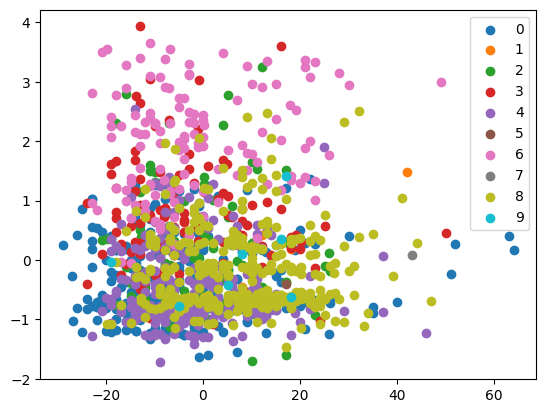

In [ ]:
## 데이터 분포 시각화 ##
from sklearn.decomposition import PCA
X = clean_df.copy()

#객체
pca = PCA(n_components=2)

#적용
pca.fit(X)
x_pca = pca.transform(X)
x_pca



#x_pca를 보기 쉽게 데이터프레임으로 만들기
pca_df = pd.DataFrame(x_pca)
#pca_df['cluster'] = clean_df['Reattack']  # 정상, 비정상 데이터 분포
# 클러스터 10개의 분포 
cluster_ids = cluster(clean_df, True)  
pca_df['cluster'] = cluster_ids
print(pca_df.head())

import matplotlib.pyplot as plt
import seaborn as sns
axs = plt.subplots()
#axs = sns.scatterplot(0, 1, hue='cluster', data=pca_df)

for i in sorted(pca_df['cluster'].unique()):
    tmp = pca_df.loc[pca_df['cluster'] == i] #해당하는 클러스터 번호일 때 그림을 그리고, for문 실행하며 위에 덧그림 
    plt.scatter(tmp[0], tmp[1])
    plt.legend(sorted(pca_df['cluster'].unique()))

In [ ]:
# trian, test 데이터셋 구성
train_test = split_dataset_kfold(clean_df, categorical_columns, True) # 미리 원핫 코딩을 했는지 안 했는지 알려주기

print(f'훈련,테스트 데이터셋(정상데이터: {len(train_test[train_test["Reattack"]==0])}, 비정상데이터: {len(train_test[train_test["Reattack"]==1])})')
print(train_test)
#train_test.to_csv("train_test.csv")

클러스터링을 위해 표준화 한 데이터셋 : 
            0         1          2         3         4         5         6    \
0     0.893683 -3.142547  11.581235 -2.537510 -0.825337 -0.649899 -0.585540   
1     0.893683  1.348511  -0.086347 -0.197025 -0.825337 -0.649899 -0.585540   
2    -1.118965  1.633658  -0.086347 -0.197025 -0.825337 -0.649899 -0.585540   
3     0.893683 -0.932661  -0.086347 -0.197025  1.211626  1.538701 -0.585540   
4     0.893683 -0.504942  -0.086347 -0.197025  1.211626 -0.649899 -0.585540   
...        ...       ...        ...       ...       ...       ...       ...   
1076 -1.118965  0.992078  -0.086347  2.143460 -0.825337  1.538701  1.707825   
1077 -1.118965  0.920791  -0.086347 -0.197025 -0.825337  1.538701  1.707825   
1078 -1.118965  1.205938  -0.086347  2.143460 -0.825337 -0.649899 -0.585540   
1079 -1.118965  1.633658  -0.086347 -0.197025 -0.825337 -0.649899 -0.585540   
1080  0.893683  1.277225  -0.086347 -0.197025 -0.825337 -0.649899 -0.585540   

          7         8     

In [ ]:
# feature selecton 없이 성능보기
k_folds(train_test,"all(109)")

1번 fold 결과입니다.

각 분할의 정확도 기록(xgb) : 0.49473684210526314
각 분할의 confusion matrix 기록(xgb) : [[23 28]
 [20 24]]
각 분할의 정확도 기록(rf) : 0.5157894736842106
각 분할의 confusion matrix 기록(rf) : [[24 27]
 [19 25]]
각 분할의 정확도 기록(svm) : 0.4842105263157895
각 분할의 confusion matrix 기록(svm) : [[ 9 42]
 [ 7 37]]
각 분할의 정확도 기록(dt) : 0.4421052631578947
각 분할의 confusion matrix 기록(dt) : [[20 31]
 [22 22]]
2번 fold 결과입니다.

각 분할의 정확도 기록(xgb) : 0.6421052631578947
각 분할의 confusion matrix 기록(xgb) : [[34 14]
 [20 27]]
각 분할의 정확도 기록(rf) : 0.6842105263157895
각 분할의 confusion matrix 기록(rf) : [[34 14]
 [16 31]]
각 분할의 정확도 기록(svm) : 0.5052631578947369
각 분할의 confusion matrix 기록(svm) : [[48  0]
 [47  0]]
각 분할의 정확도 기록(dt) : 0.5789473684210527
각 분할의 confusion matrix 기록(dt) : [[32 16]
 [24 23]]
3번 fold 결과입니다.

각 분할의 정확도 기록(xgb) : 0.5368421052631579
각 분할의 confusion matrix 기록(xgb) : [[26 25]
 [19 25]]
각 분할의 정확도 기록(rf) : 0.5789473684210527
각 분할의 confusion matrix 기록(rf) : [[29 22]
 [18 26]]
각 분할의 정확도 기록(svm) : 0.49473684210526314
각 분할의 confu

In [ ]:
#### Filter Method ####
mrmr_feature = pymrmr.mRMR(train_test.drop('Reattack', axis=1),'MIQ',90) # 80개 뽑았을 때 가장 좋음
print(mrmr_feature)

mrmr_feature.append('Reattack')
train_test_mrmr = train_test[mrmr_feature]

['Smoking (0,1,2)_0.0', 'EVD', 'unspecified cardiovascular disease', 'corpus callosum', 'lentiform nucleus', 'Employment status', 'centrum semiovale', 'Alcohol (0,1,2)_1.0', 'Psychosocial stress', 'Marital status', 'external capsule', 'periventricular white matter', 'cerebellar peduncle', 'Congestive heart failure', 'Smoking (0,1,2)_1.0', 'Midbrain', 'Alcohol (0,1,2)_0.0', 'CR', 'Venous thrombosis', 'Hypothalamus', 'lacunar', 'CKD', 'cerebral hemisphere', 'Smoking (0,1,2)_2.0', 'Chronic liver disease', 'Total number of OP(min)', 'Oral contraceptive use', 'Sylvian fissure', 'cerebellar vermis', 'SCA', 'COPD', 'Pons', 'GDC_stent', 'cerebral peduncle', 'Asymptomatic carotid stenosis', 'BA', 'Atrial fibrillation_Adm', 'IC', 'ACA', 'Smoking (0,1,2)_30.0', 'PICA', 'hippocampus', 'shunt', 'Age', 'Alcohol (0,1,2)_2.0', 'subcortical white matter', 'Cerebellum', 'VA', 'GDC_embolization', 'HTN_medication', 'insula', 'Medulla', 'Atrial fibrillation_PMH', 'Initial mental state', 'Craniectomy', 'Fam

In [ ]:
k_folds(train_test_mrmr,"mrmr(90)")

1번 fold 결과입니다.

각 분할의 정확도 기록(xgb) : 0.5157894736842106
각 분할의 confusion matrix 기록(xgb) : [[26 25]
 [21 23]]
각 분할의 정확도 기록(rf) : 0.5473684210526316
각 분할의 confusion matrix 기록(rf) : [[25 26]
 [17 27]]
각 분할의 정확도 기록(svm) : 0.4842105263157895
각 분할의 confusion matrix 기록(svm) : [[ 9 42]
 [ 7 37]]
각 분할의 정확도 기록(dt) : 0.5052631578947369
각 분할의 confusion matrix 기록(dt) : [[23 28]
 [19 25]]
2번 fold 결과입니다.

각 분할의 정확도 기록(xgb) : 0.6421052631578947
각 분할의 confusion matrix 기록(xgb) : [[34 14]
 [20 27]]
각 분할의 정확도 기록(rf) : 0.6105263157894737
각 분할의 confusion matrix 기록(rf) : [[33 15]
 [22 25]]
각 분할의 정확도 기록(svm) : 0.5052631578947369
각 분할의 confusion matrix 기록(svm) : [[48  0]
 [47  0]]
각 분할의 정확도 기록(dt) : 0.5368421052631579
각 분할의 confusion matrix 기록(dt) : [[28 20]
 [24 23]]
3번 fold 결과입니다.

각 분할의 정확도 기록(xgb) : 0.5157894736842106
각 분할의 confusion matrix 기록(xgb) : [[23 28]
 [18 26]]
각 분할의 정확도 기록(rf) : 0.5789473684210527
각 분할의 confusion matrix 기록(rf) : [[29 22]
 [18 26]]
각 분할의 정확도 기록(svm) : 0.49473684210526314
각 분할의 confus

In [ ]:
fs = wrapper_method(train_test_mrmr.drop('Reattack', axis=1), train_test_mrmr['Reattack'], MODELS, 'BACK')
print(fs)

     Smoking (0,1,2)_0.0  EVD  unspecified cardiovascular disease  \
0                      0  0.0                                 0.0   
1                      0  0.0                                 0.0   
2                      1  0.0                                 0.0   
3                      0  0.0                                 0.0   
4                      0  0.0                                 0.0   
..                   ...  ...                                 ...   
469                    0  0.0                                 0.0   
470                    1  0.0                                 0.0   
471                    1  0.0                                 0.0   
472                    1  0.0                                 0.0   
473                    1  0.0                                 0.0   

     corpus callosum  lentiform nucleus  Employment status  centrum semiovale  \
0                0.0                0.0                1.0                0.0   
1        

In [ ]:
k_folds(train_test_mrmr,"wrapper(15)",fs)

1번 fold 결과입니다.

각 분할의 정확도 기록(xgb) : 0.5894736842105263
각 분할의 confusion matrix 기록(xgb) : [[25 26]
 [13 31]]
각 분할의 정확도 기록(rf) : 0.5684210526315789
각 분할의 confusion matrix 기록(rf) : [[28 23]
 [18 26]]
각 분할의 정확도 기록(svm) : 0.5368421052631579
각 분할의 confusion matrix 기록(svm) : [[ 8 43]
 [ 1 43]]
각 분할의 정확도 기록(dt) : 0.4421052631578947
각 분할의 confusion matrix 기록(dt) : [[21 30]
 [23 21]]
2번 fold 결과입니다.

각 분할의 정확도 기록(xgb) : 0.5578947368421052
각 분할의 confusion matrix 기록(xgb) : [[25 23]
 [19 28]]
각 분할의 정확도 기록(rf) : 0.6421052631578947
각 분할의 confusion matrix 기록(rf) : [[33 15]
 [19 28]]
각 분할의 정확도 기록(svm) : 0.5368421052631579
각 분할의 confusion matrix 기록(svm) : [[ 7 41]
 [ 3 44]]
각 분할의 정확도 기록(dt) : 0.5789473684210527
각 분할의 confusion matrix 기록(dt) : [[26 22]
 [18 29]]
3번 fold 결과입니다.

각 분할의 정확도 기록(xgb) : 0.5789473684210527
각 분할의 confusion matrix 기록(xgb) : [[20 31]
 [ 9 35]]
각 분할의 정확도 기록(rf) : 0.5368421052631579
각 분할의 confusion matrix 기록(rf) : [[27 24]
 [20 24]]
각 분할의 정확도 기록(svm) : 0.49473684210526314
각 분할의 confus

In [ ]:

    #k_folds(df[['dis_mrs', 'dbp', 'qq', 'dis_nih', 'hosdays', 'tx_throm', 'dtx_plt', 'su_hosdays', 'dtx_statin', 'hx_htn', 'pre_mrs', 'atx_coa',  # RF Feature 조합
    #           'age', 'hx_af', 'sbp','end1_kind']],[])
    #k_folds(df[['dis_mrs', 'dbp', 'qq','su', 'dis_nih', 'hosdays', 'tx_throm', 'dtx_plt','MI' ,'su_hosdays', 'hx_htn', 'atx_plt', 'Stroke_edu', 'atx_coa'    # XGB Feature 조합
    #            ,'sbp','end1_kind']], [])

    #k_folds(df[['qq','hosdays','tx_throm', 'end1_kind']], [])

    #k_folds(df[['qq', 'dtx_coa', 'ini_nih', 'atx_plt', 'hosdays', 'dis_nih', 'su_hosdays', 'Stroke_edu', 'MI', 'atx_coa', 'end1_kind']], [])  # 경민 실험 피쳐들
 

    #k_folds(train_test[['delta_nih', 'hx_dm', 'dtx_coa', 'ini_nih', 'atx_plt', 'hosdays', 'dis_nih', 'dis_mrs', 'hx_af', 'dtx_plt', 'su_hosdays','Stroke_edu','MI','atx_coa', 'end1_kind']], [])
    #k_folds(train_test[['delta_nih', 'dtx_coa', 'ini_nih', 'atx_plt', 'hosdays', 'dis_nih', 'su_hosdays', 'Stroke_edu', 'MI', 'atx_coa','end1_kind']], [])

    #feature_name = ['delta_nih', 'hx_dm', 'dtx_coa', 'ini_nih', 'atx_plt', 'hosdays', 'dis_nih', 'dis_mrs', 'hx_af', 'dtx_plt', 'su_hosdays','Stroke_edu','MI','atx_coa']

    '''
    ## Combination feature selection
    for i in range(10, 11):

        comb = list(combinations(feature_name, i))

        acc_rf_list=[]
        acc_xgb_list = []

        for n in comb:
            n = list(n)
            n.append('end1_kind')
            acc_rf,acc_xgb = k_folds(train_test[n],[])
            acc_rf_list.append(acc_rf)
            acc_xgb_list.append(acc_xgb)

        print(f'최고 성능(rf) : {max(acc_rf_list)}\n 조합 : {comb[acc_rf_list.index(max(acc_rf_list))]}')
        print(f'최고 성능(xgb) : {max(acc_xgb_list)}\n 조합 : {comb[acc_xgb_list.index(max(acc_xgb_list))]}')
    '''

    '''
    # feature importance
    xgb_clf = XGBClassifier()
    xgb_clf.fit(selected_mrmr.drop('end1_kind',axis=1)[fs['XGB']], selected_mrmr['end1_kind'])
    sorted_imp_xgb = np.argsort(xgb_clf.feature_importances_)[::-1]

    rf_clf = RandomForestClassifier()
    rf_clf.fit(selected_mrmr.drop('end1_kind',axis=1)[fs['RF']], selected_mrmr['end1_kind'])
    sorted_imp_rf = np.argsort(rf_clf.feature_importances_)[::-1]


    # feature selection
    for i in range(5, 15):
        print(f'feature 의 개수 : {i}')

        feature = list(selected_mrmr.columns[sorted_imp_xgb[:i]])
        print(feature)
        feature.append('end1_kind')

        k_folds(selected_mrmr[feature],[])

    '''

    '''
    ## feature selection 전 성능 확인
    xgb_clf = xgb.XGBClassifier(random_state=123)
    xgb_clf.fit(train.drop('end1_kind', axis=1), train['end1_kind'])
    pred = xgb_clf.predict(test.drop('end1_kind', axis=1))
    print(f"Accuracy: {accuracy_score(test['end1_kind'], pred)}")
    print(f"Confusion Matrix: \n{confusion_matrix(test['end1_kind'], pred)}")

    tmp_rf = RandomForestClassifier(random_state=123)
    tmp_rf.fit(train.drop('end1_kind', axis=1), train['end1_kind'])
    pred = tmp_rf.predict(test.drop('end1_kind', axis=1))
    print(f"Accuracy: {accuracy_score(test['end1_kind'], pred)}")
    print(f"Confusion Matrix: \n{confusion_matrix(test['end1_kind'], pred)}")


    ## MRMR feature selection
    mrmr_selected_features = mrmr(clean_df)
    mrmr_selected_features.append('end1_kind')

    train_selected_mrmr = train[mrmr_selected_features]
    #val_selected_mrmr = val[mrmr_selected_features]
    test_selected_mrmr = test[mrmr_selected_features]
    print(train_selected_mrmr)
    '''


    '''
    ## Wrapper Method feature selection (Back)
    fs = wrapper_method(train_selected_mrmr.drop('end1_kind', axis=1), train_selected_mrmr['end1_kind'], MODELS, 'BACK')

    X_train_rf = train_selected_mrmr.drop('end1_kind', axis=1)[fs['RF']]
    y_train_rf = train_selected_mrmr['end1_kind']
    X_test_rf = test_selected_mrmr.drop('end1_kind', axis=1)[fs['RF']]
    y_test_rf = test_selected_mrmr['end1_kind']

    X_train_xgb = train_selected_mrmr.drop('end1_kind', axis=1)[fs['XGB']]
    y_train_xgb = train_selected_mrmr['end1_kind']
    X_test_xgb = test_selected_mrmr.drop('end1_kind', axis=1)[fs['XGB']]
    y_test_xgb = test_selected_mrmr['end1_kind']

    ## mRMR + Wrapper 적용후 성능 확인
    xgb_clf = XGBClassifier(random_state=123)
    xgb_clf.fit(X_train_xgb, y_train_xgb)
    pred = xgb_clf.predict(X_test_xgb)
    print(f"Accuracy: {accuracy_score(y_test_xgb, pred)}")
    print(f"Confusion Matrix: \n{confusion_matrix(y_test_xgb, pred)}")

    tmp_rf = RandomForestClassifier(random_state=123)
    tmp_rf.fit(X_train_rf, y_train_rf)
    pred = tmp_rf.predict(X_test_rf)
    print(f"Accuracy: {accuracy_score(y_test_rf, pred)}")
    print(f"Confusion Matrix: \n{confusion_matrix(y_test_rf, pred)}")

    # feature importance
    xgb_clf = XGBClassifier()
    xgb_clf.fit(X_train_xgb, y_train_xgb)
    sorted_imp_xgb = np.argsort(xgb_clf.feature_importances_)[::-1]

    rf_clf = RandomForestClassifier()
    rf_clf.fit(X_train_rf, y_train_rf)
    sorted_imp_rf = np.argsort(rf_clf.feature_importances_)[::-1]

    acc_xgb = []
    acc_rf = []
    pres_xgb = []
    pres_rf = []
    recall_xgb =[]
    recall_rf = []

    final_acc_xgb = []
    final_acc_rf = []
    final_recall_xgb = []
    final_recall_rf = []
    final_feature_xgb = []
    final_feature_rf = []
    '''
    '''
    ## Combination feature selection
    for i in range(5,10):

        comb_xgb = list(combinations(X_train_xgb.columns,i))
        comb_rf = list(combinations(X_train_rf.columns, i))

        for n in comb_xgb:
            xgb_clf = XGBClassifier()
            xgb_clf.fit(X_train_xgb.drop(list(n), axis=1), y_train_xgb)
            pred = xgb_clf.predict(X_test_xgb.drop(list(n), axis=1))
            acc_xgb.append(accuracy_score(y_test_xgb, pred))
            recall_xgb.append(precision_score(y_test_xgb, pred))

        #print(f"Best Accuracy (XGB): {max(acc_xgb)}\n{n}")
        #print(f"Best Combination: \n{recall_xgb[acc_xgb.index(max(acc_xgb))]}\n")
        final_acc_xgb.append(max(acc_xgb))
        final_feature_xgb.append(comb_xgb[acc_xgb.index(max(acc_xgb))])
        final_recall_xgb.append(recall_xgb[acc_xgb.index(max(acc_xgb))])


        for m in comb_rf:
            tmp_rf = RandomForestClassifier()
            tmp_rf.fit(X_train_rf.drop(list(m), axis=1), y_train_rf)
            pred = tmp_rf.predict(X_test_rf.drop(list(m), axis=1))
            acc_rf.append(accuracy_score(y_test_rf, pred))
            recall_rf.append(precision_score(y_test_rf, pred))

        #print(f"Best Accuracy (XGB): {max(acc_rf)}\n{n}")
        #print(f"Best Combination: \n{recall_rf[acc_rf.index(max(acc_rf))]}\n")

        final_acc_rf.append(max(acc_rf))
        final_feature_rf.append(comb_rf[acc_rf.index(max(acc_rf))])
        final_recall_rf.append(recall_rf[acc_rf.index(max(acc_rf))])


    print(final_acc_xgb)
    print(final_feature_xgb)
    print(final_recall_xgb)

    print(final_acc_rf)
    print(final_feature_rf)
    print(final_recall_rf)
    '''

    '''
    for i in range(4, 20):
        xgb_clf = XGBClassifier()
        xgb_clf.fit(X_train_xgb.loc[:,X_train_xgb.columns[sorted_imp_xgb[:i]]], y_train_xgb)
        pred = xgb_clf.predict(X_test_xgb.loc[:,X_train_xgb.columns[sorted_imp_xgb[:i]]])
        print(f"Best Accuracy (XGB): {accuracy_score(y_test_xgb, pred)}\n{X_train_xgb.columns[sorted_imp_xgb[:i]]}")
        print(f"Confusion Matrix: \n{confusion_matrix(y_test_xgb, pred)}\n")

        acc_xgb.append(accuracy_score(y_test_xgb, pred))
        pres_xgb.append(precision_score(y_test_xgb, pred))
        recall_xgb.append(recall_score(y_test_xgb, pred))
       
        tmp_rf = RandomForestClassifier()
        tmp_rf.fit(X_train_rf.loc[:,X_train_rf.columns[sorted_imp_rf[:i]]], y_train_rf)
        pred = tmp_rf.predict(X_test_rf.loc[:,X_train_rf.columns[sorted_imp_rf[:i]]])
        print(f"Best Accuracy (RF): {accuracy_score(y_test_rf, pred)}\n{X_train_rf.columns[sorted_imp_rf[:i]]}")
        print(f"Confusion Matrix: \n{confusion_matrix(y_test_rf, pred)}\n")
       
        acc_rf.append(accuracy_score(y_test_rf, pred))
        pres_rf.append(precision_score(y_test_rf, pred))
        recall_rf.append(recall_score(y_test_rf, pred))
    '''

    '''
        for j in [100,200,300,400,500,600]:
            tmp_rf = RandomForestClassifier(n_estimators=j)
            tmp_rf.fit(X_train_rf.drop(X_train_rf.columns[sorted_imp_rf[:i]], axis=1), y_train_rf)
            pred = tmp_rf.predict(X_test_rf.drop(X_train_rf.columns[sorted_imp_rf[:i]], axis=1))
            print(f'n_estimators : {j}\n')
            print(f"Best Accuracy (RF): {accuracy_score(y_test_rf, pred)}\n{X_train_rf.columns[sorted_imp_rf[:i]]}")
            print(f"Confusion Matrix: \n{confusion_matrix(y_test_rf, pred)}\n")    
    '''
    '''

    # 정확도, 정밀도, 재현율 시각화
    x_value = list(range(4,20))

    plt.subplot(1,2,1)
    plt.plot(x_value, acc_xgb)
    plt.plot(x_value, pres_xgb)
    plt.plot( x_value, recall_xgb)
    plt.title('Plot_XGB')
    plt.legend(['acc', 'pres', 'recall'])

    plt.subplot(1, 2, 2)
    plt.plot(x_value, acc_rf)
    plt.plot(x_value, pres_rf)
    plt.plot(x_value, recall_rf)
    plt.title('Plot_RF')
    plt.legend(['acc','pres','recall'])

    plt.show()
    '''